In [ ]:
import re
import nltk
import pyspark 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, ArrayType, StringType
from pyspark.sql.functions import col, sum, length, when, count, explode, udf, expr
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from nltk.stem import WordNetLemmatizer

In [2]:
spark = SparkSession.builder\
	.master("local").appName("Preprocessing").getOrCreate()

24/12/10 16:52:44 WARN Utils: Your hostname, hungnd-VirtualBox resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
24/12/10 16:52:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/10 16:52:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.csv("hdfs://localhost:9000/final/", header=True, inferSchema=True)
df.show()
df.printSchema()

+------+---------+---------------+--------------------+
|ItemID|Sentiment|SentimentSource|       SentimentText|
+------+---------+---------------+--------------------+
|     1|        0|   Sentiment140|                 ...|
|     2|        0|   Sentiment140|                 ...|
|     3|        1|   Sentiment140|              omg...|
|     4|        0|   Sentiment140|          .. Omga...|
|     5|        0|   Sentiment140|         i think ...|
|     6|        0|   Sentiment140|         or i jus...|
|     7|        1|   Sentiment140|       Juuuuuuuuu...|
|     8|        0|   Sentiment140|       Sunny Agai...|
|     9|        1|   Sentiment140|      handed in m...|
|    10|        1|   Sentiment140|      hmmmm.... i...|
|    11|        0|   Sentiment140|      I must thin...|
|    12|        1|   Sentiment140|      thanks to a...|
|    13|        0|   Sentiment140|      this weeken...|
|    14|        0|   Sentiment140|     jb isnt show...|
|    15|        0|   Sentiment140|     ok thats 

In [4]:
print(f"Number of rows: {df.count()}")
print(f"Number of columns: {len(df.columns)}")

Number of rows: 1578627
Number of columns: 4


In [5]:
# KCheck Null value
null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
print("Null counts:")
null_counts.show()

# Remove Null value 
df = df.dropna()

# Remove duplicate
duplicate_count = df.count() - df.dropDuplicates().count()
print(f"Number of duplicate rows: {duplicate_count}")
df = df.dropDuplicates()


Null counts:


+------+---------+---------------+-------------+
|ItemID|Sentiment|SentimentSource|SentimentText|
+------+---------+---------------+-------------+
|     0|        0|              0|            0|
+------+---------+---------------+-------------+



Number of duplicate rows: 0


+---------------+-------+
|SentimentSource|  count|
+---------------+-------+
|   Sentiment140|1577278|
|         Kaggle|   1349|
+---------------+-------+



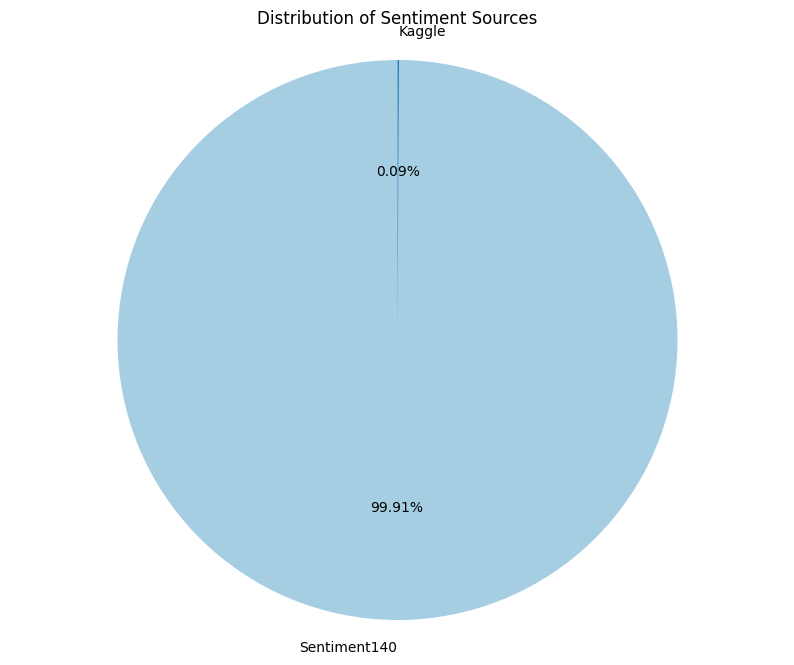

In [6]:
# Sentiment source
df.groupBy("SentimentSource").count().show()
sentiment_source_count = df.groupBy("SentimentSource").count().toPandas()

plt.figure(figsize=(10, 8))
plt.pie(
    sentiment_source_count["count"],
    labels=sentiment_source_count["SentimentSource"],
    autopct="%.2f%%",
    startangle=90,
    colors=plt.cm.Paired.colors,
)
plt.title("Distribution of Sentiment Sources")
plt.axis("equal")
plt.show()

+---------+------+-----------------+
|Sentiment| count|       percentage|
+---------+------+-----------------+
|        1|790185|50.05520620133825|
|        0|788442|49.94479379866175|
+---------+------+-----------------+



(-1.0999999999964865,
 1.0999999999797305,
 -1.099999999979835,
 1.0999999999990397)

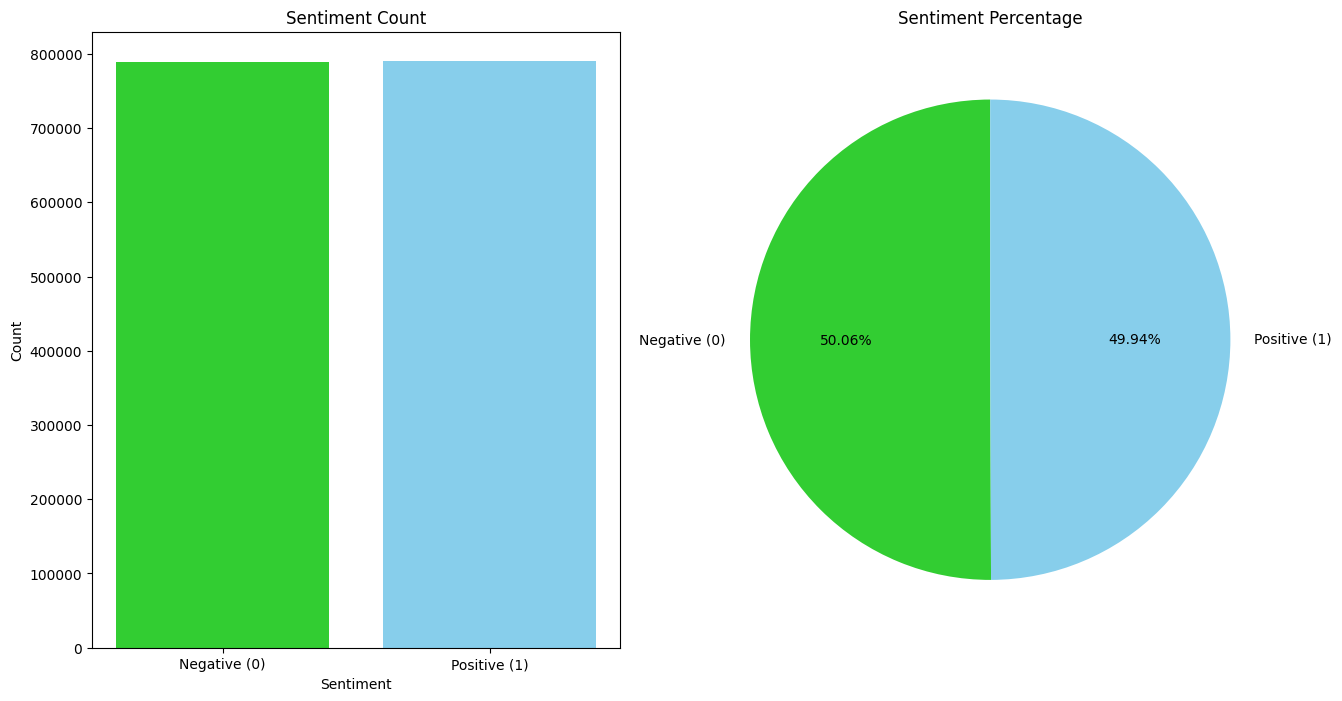

In [7]:
#Sentiment statistic
total_rows = df.count()
df.groupBy("Sentiment").count() \
    .withColumn("percentage", (col("count") / total_rows) * 100) \
    .show()

sentiment_stat = df.groupBy("Sentiment").count() \
    .withColumn("percentage", (col("count") / total_rows) * 100)

sentiment_stat_pd = sentiment_stat.toPandas()
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.bar(
    sentiment_stat_pd["Sentiment"], 
    sentiment_stat_pd["count"], 
    color=["skyblue", "limegreen"]
)
plt.title("Sentiment Count")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks([0, 1], ["Negative (0)", "Positive (1)"])

plt.subplot(1,2,2)
plt.pie(
    sentiment_stat_pd["percentage"], 
    labels=["Negative (0)", "Positive (1)"], 
    autopct="%.2f%%", 
    colors=["limegreen", "skyblue" ],
    startangle=90
)
plt.title("Sentiment Percentage")
plt.axis("equal")

+-------+------------------+
|summary|       text_length|
+-------+------------------+
|  count|           1578627|
|   mean| 74.62733185229949|
| stddev|36.135526756445174|
|    min|                 6|
|    max|               374|
+-------+------------------+



Text(0.5, 0, 'Text Length')

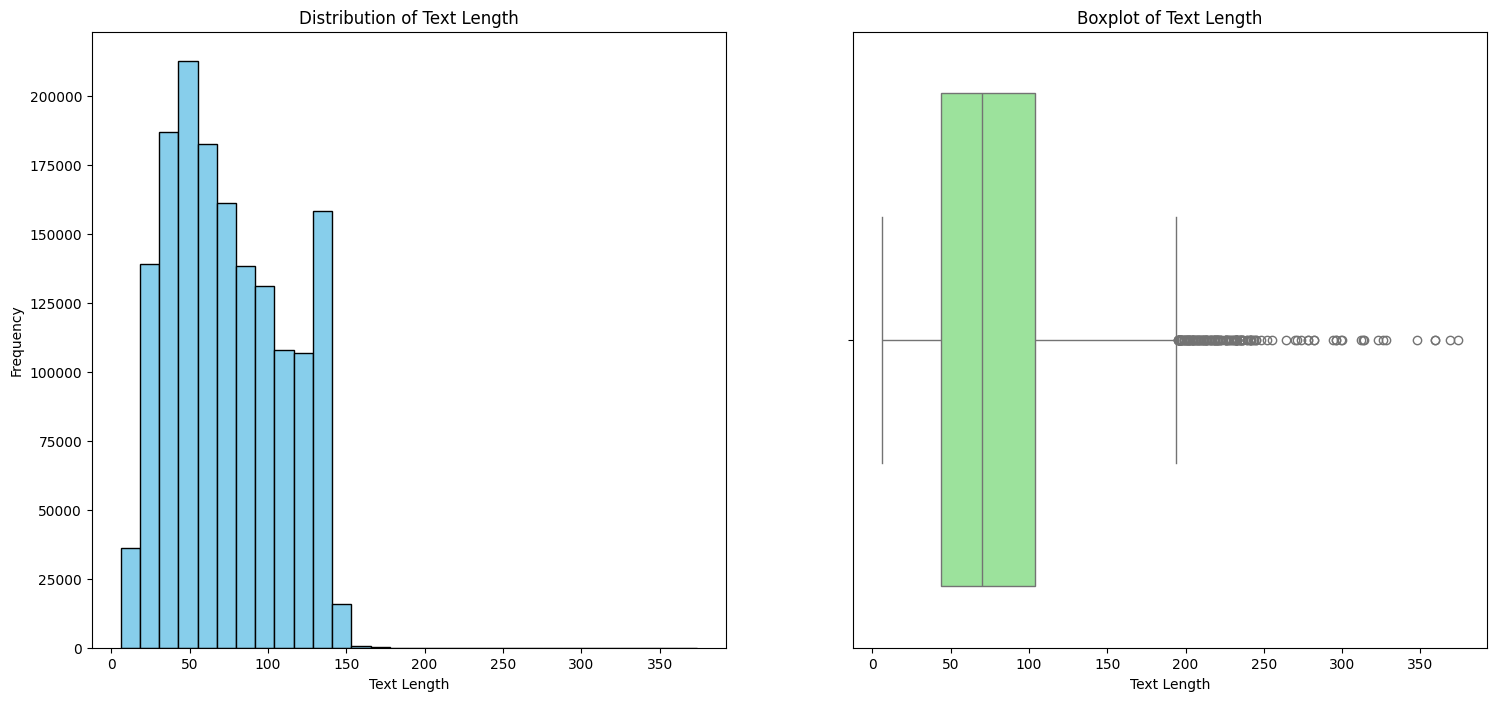

In [8]:
# Text length statistics:
df = df.withColumn("text_length", length("SentimentText"))
df.select("text_length").describe().show()

#Visualize
text_length_pd = df.select("text_length").toPandas()
plt.figure(figsize=(18, 8))

plt.subplot(1,2,1)
plt.hist(text_length_pd["text_length"], bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of Text Length")
plt.xlabel("Text Length")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
sns.boxplot(x=text_length_pd["text_length"], color="lightgreen")
plt.title("Boxplot of Text Length")
plt.xlabel("Text Length")


+-------+-----------------+
|summary|      text_length|
+-------+-----------------+
|  count|          1578405|
|   mean|74.60727886695747|
| stddev| 36.0956168478285|
|    min|                6|
|    max|              180|
+-------+-----------------+



Text(0.5, 0, 'Text Length')

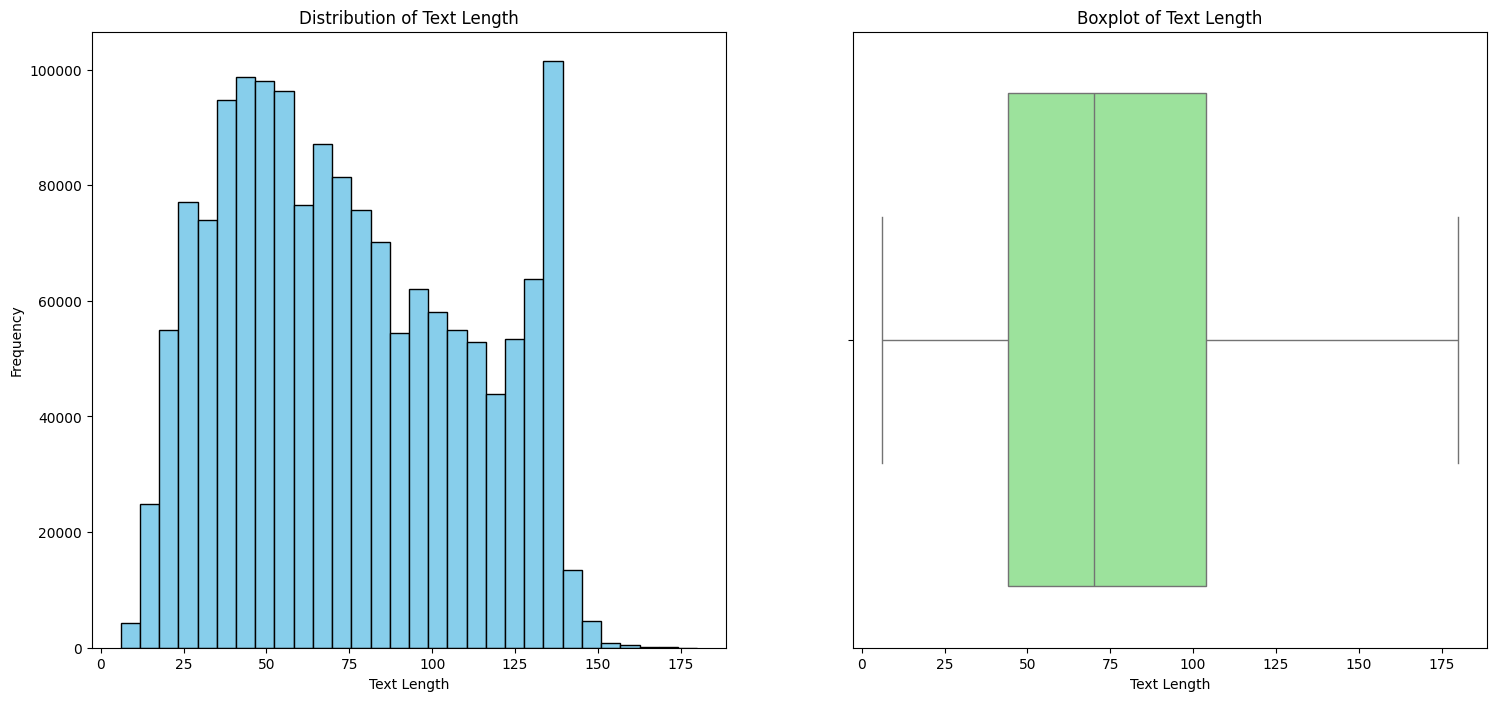

In [9]:
# Remove too short or too long text_length
df = df.filter((col("text_length") > 5) & (col("text_length") < 181))
df.select("text_length").describe().show()

# Visualize
text_length_pd = df.select("text_length").toPandas()

plt.figure(figsize=(18, 8))

plt.subplot(1,2,1)
plt.hist(text_length_pd["text_length"], bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of Text Length")
plt.xlabel("Text Length")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
sns.boxplot(x=text_length_pd["text_length"], color="lightgreen")
plt.title("Boxplot of Text Length")
plt.xlabel("Text Length")


+---------+-----------------+
|Sentiment| avg(text_length)|
+---------+-----------------+
|        1|74.19134374153501|
|        0|75.02407447104024|
+---------+-----------------+



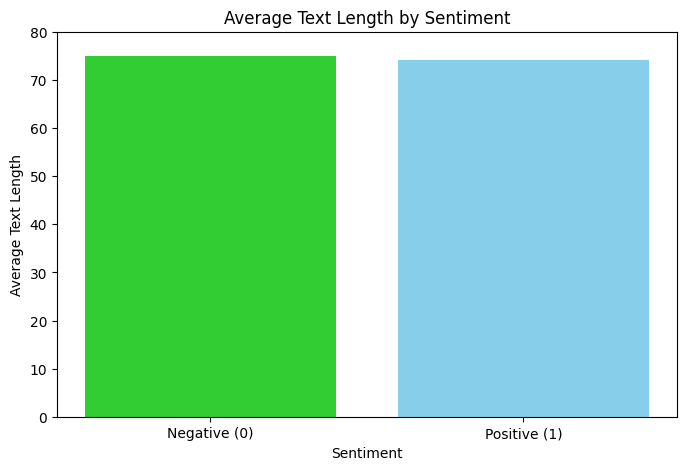

In [10]:
df.groupBy("Sentiment").avg("text_length").show()

avg_text_length = df.groupBy("Sentiment").avg("text_length").toPandas()

avg_text_length.columns = ["Sentiment", "Avg_Text_Length"]

plt.figure(figsize=(8, 5))
plt.bar(
    avg_text_length["Sentiment"], 
    avg_text_length["Avg_Text_Length"], 
    color=["skyblue", "limegreen"]
)
plt.title("Average Text Length by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Average Text Length")
plt.xticks([0, 1], ["Negative (0)", "Positive (1)"])
plt.ylim(0, avg_text_length["Avg_Text_Length"].max() + 5)
plt.show()

[nltk_data] Downloading package wordnet to /home/hungnd/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


+----+------+
|word| count|
+----+------+
|    |957526|
|  im|177411|
| day|102879|
|good| 87948|
| get| 85494|
|like| 78856|
|  go| 76727|
|   u| 67033|
|dont| 66705|
|love| 66686|
+----+------+
only showing top 10 rows



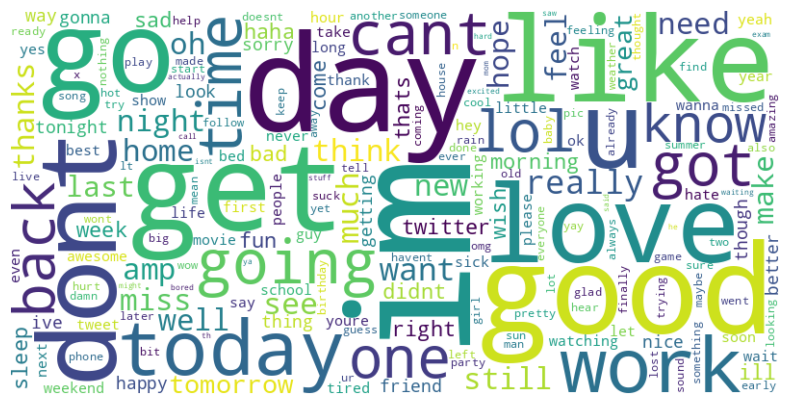

/tmp/ipykernel_15360/1502640765.py:87: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="word", data=word_counts_df.head(20), palette="Blues_d")


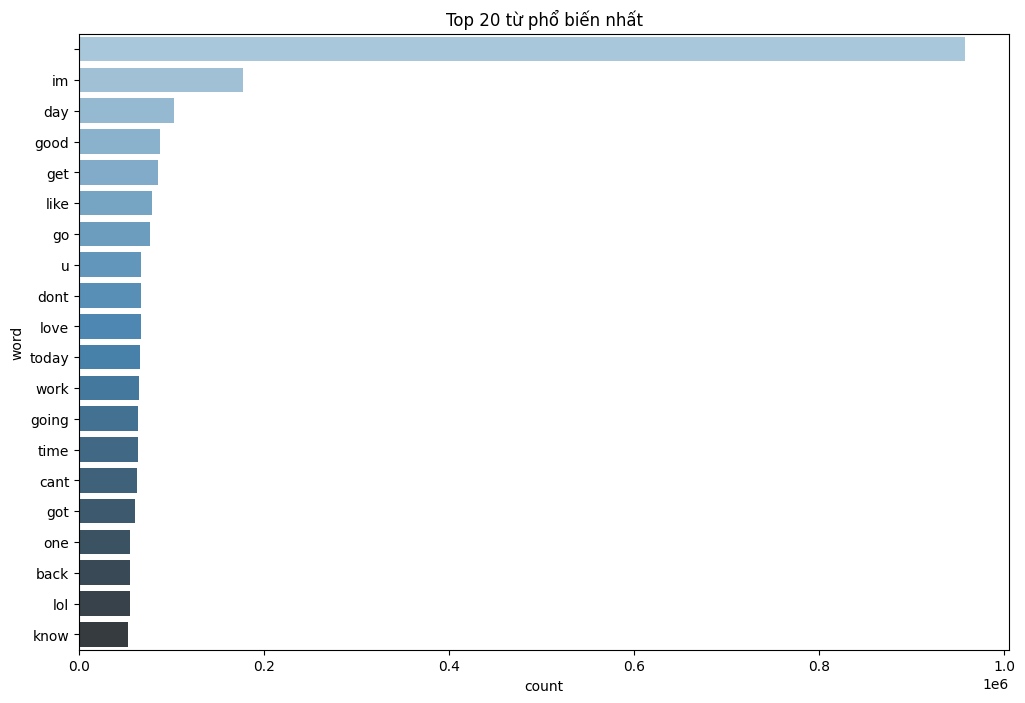

In [11]:
import re
import nltk
from pyspark.sql import functions as F
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import length, col, expr, udf
from nltk.stem import WordNetLemmatizer
from pyspark.sql.types import ArrayType, StringType

# Tải xuống bộ từ điển của NLTK
nltk.download('wordnet')

# Khởi tạo lemmatizer
lemmatizer = WordNetLemmatizer()

# Định nghĩa hàm chuẩn hóa văn bản
def normalize_text(df):
    # Loại bỏ URL
    df = df.withColumn("SentimentText", F.regexp_replace("SentimentText", r"http\S+", ""))
    # Loại bỏ username (chữ @)
    df = df.withColumn("SentimentText", F.regexp_replace("SentimentText", r"@[\w]+", ""))
    # Loại bỏ hashtag (chữ #)
    df = df.withColumn("SentimentText", F.regexp_replace("SentimentText", r"#\w+", ""))
    # Loại bỏ số và ký tự đặc biệt
    df = df.withColumn("SentimentText", F.regexp_replace("SentimentText", r"[^a-zA-Z\s]", ""))
    # Chuyển văn bản thành chữ thường
    df = df.withColumn("SentimentText", F.lower("SentimentText"))
    # Loại bỏ khoảng trắng thừa ở đầu và cuối văn bản
    df = df.withColumn("SentimentText", F.trim("SentimentText"))
    
    return df

# Định nghĩa UDF để lemmatize các từ
def lemmatize_words(words):
    return [lemmatizer.lemmatize(word) for word in words]

# Đăng ký UDF trong PySpark
lemmatize_udf = udf(lemmatize_words, ArrayType(StringType()))

# Bước 1: Áp dụng chuẩn hóa văn bản
df = normalize_text(df)

# Bước 2: Tokenize (Tách từ)
tokenizer = Tokenizer(inputCol="SentimentText", outputCol="words")
df = tokenizer.transform(df)

# Bước 3: Loại bỏ Stop Words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df = remover.transform(df)

# Bước 4: Stemming/Lemmatization (Sử dụng NLTK Lemmatizer)
df = df.withColumn("lemmatized_words", lemmatize_udf("filtered_words"))

# Bước 5: Tính tần suất từ (Word Frequency)
word_counts = df.withColumn("word", F.explode("lemmatized_words")) \
                .groupBy("word").count() \
                .orderBy("count", ascending=False)

# Lọc các từ có tần suất dưới 5 lần
min_frequency = 5
filtered_word_counts = word_counts.filter(word_counts['count'] >= min_frequency)

# Hiển thị các từ có tần suất xuất hiện trên 5 lần
filtered_word_counts.show(10)

# Bước 6: Vẽ Word Cloud cho từ phổ biến
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Chuyển đổi word counts thành dictionary cho WordCloud
word_freq = {row['word']: row['count'] for row in filtered_word_counts.collect()}

# Tạo Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq)

# Vẽ Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Bước 7: Visualize tần suất từ
import seaborn as sns

# Chuyển word_counts thành DataFrame và vẽ đồ thị
word_counts_df = word_counts.toPandas()
plt.figure(figsize=(12, 8))
sns.barplot(x="count", y="word", data=word_counts_df.head(20), palette="Blues_d")
plt.title("Top 20 từ phổ biến nhất")
plt.show()


In [13]:
df.show()

+------+---------+---------------+--------------------+-----------+--------------------+--------------------+--------------------+
|ItemID|Sentiment|SentimentSource|       SentimentText|text_length|               words|      filtered_words|    lemmatized_words|
+------+---------+---------------+--------------------+-----------+--------------------+--------------------+--------------------+
|    62|        1|   Sentiment140|i always get what...|         27|[i, always, get, ...| [always, get, want]| [always, get, want]|
|   194|        1|   Sentiment140|tell  i said happ...|         44|[tell, , i, said,...|[tell, , said, ha...|[tell, , said, ha...|
|   436|        0|   Sentiment140|i hope everyone i...|        136|[i, hope, everyon...|[hope, everyone, ...|[hope, everyone, ...|
|   474|        0|   Sentiment140|all my friends ar...|        101|[all, my, friends...|[friends, gone, h...|[friend, gone, ha...|
|   619|        0|   Sentiment140|bcds closed i gue...|         36|[bcds, closed, i

In [19]:
df.coalesce(1).write.format("parquet").save("hdfs://localhost:9000/final/cleaned_data")

In [21]:
# Đọc file parquet từ HDFS
df = spark.read.parquet("hdfs://localhost:9000/final/cleaned_data/")

# Hiển thị vài dòng đầu tiên của DataFrame
df.show()


+------+---------+---------------+--------------------+-----------+--------------------+--------------------+--------------------+
|ItemID|Sentiment|SentimentSource|       SentimentText|text_length|               words|      filtered_words|    lemmatized_words|
+------+---------+---------------+--------------------+-----------+--------------------+--------------------+--------------------+
|    62|        1|   Sentiment140|i always get what...|         27|[i, always, get, ...| [always, get, want]| [always, get, want]|
|   194|        1|   Sentiment140|tell  i said happ...|         44|[tell, , i, said,...|[tell, , said, ha...|[tell, , said, ha...|
|   436|        0|   Sentiment140|i hope everyone i...|        136|[i, hope, everyon...|[hope, everyone, ...|[hope, everyone, ...|
|   474|        0|   Sentiment140|all my friends ar...|        101|[all, my, friends...|[friends, gone, h...|[friend, gone, ha...|
|   619|        0|   Sentiment140|bcds closed i gue...|         36|[bcds, closed, i